In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%aimport util
from util import *
%autoreload 1

from PIL import Image
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def load_dataset(delighted_dirs, lighted_dirs):
    delighted_data = {}
    for mesh, mesh_dir in delighted_dirs.items():
        mesh_im = Image.open(mesh_dir + '%s_HD_BC.tga' % mesh, 'r')
        mesh_array = zero_rgb(np.array(mesh_im))
        mesh_array = mesh_array[:,:,:3]
        delighted_data[mesh] = mesh_array

    lighted_data = []
    for t, mesh, v, mesh_dir in lighted_dirs:
        lit_file = '%s%s_%s_%s_Lit.tga' % (mesh_dir, t, mesh, v)
        if not os.path.exists(lit_file):
            continue
        mesh_im = Image.open(lit_file, 'r')
        meshes = np.array(mesh_im)[:,:,:3]
        lighted_data.append((mesh, meshes))
        
    return delighted_data, lighted_data

In [26]:
delighted_dirs, lighted_dirs = scan_lighted_delighted('data/')
delighted_data, lighted_data = load_dataset(delighted_dirs, lighted_dirs)
test_meshes = ['Mesh_000003', 'Mesh_000006']
train_lighted_data = [(label, arr) for label, arr in lighted_data if label not in test_meshes]
test_lighted_data = [(label, arr) for label, arr in lighted_data if label in test_meshes]
np.random.seed(0)
np.random.shuffle(train_lighted_data)

In [100]:
GEN_ENCODER = 'gen_encoder'
GEN_MID = 'gen_mid'
GEN_DECODER = 'gen_decoder'
DISC_CONV = 'disc_conv'
DISC_FC = 'disc_fc'

def get_dimension_name(stage, layer_num):
    return 'dims_' + stage + '_' + str(layer_num)

def get_weight_name(stage, layer_num):
    return 'w_' + stage + '_' + str(layer_num)
    
def get_bias_name(stage, layer_num):
    return 'b_' + stage + '_' + str(layer_num)

FULL_HEIGHT = 1024
TRAIN_HEIGHT = 32
TEST_HEIGHT = FULL_HEIGHT

FILTER_SIZE = 3
INPUT_DEPTH = 3

# output depths of the layers
GEN_ENCODER_DEPTHS = [4, 8, 16]
GEN_MID_DEPTH = GEN_ENCODER_DEPTHS[-1]
GEN_DECODER_DEPTHS = [8, 4, 3]

DISC_CONV_DEPTHS = [4, 8, 16]
DISC_FC_SIZES = [256, 128, 1]

In [101]:
gen_layer_dimensions = {}
prev_depth = INPUT_DEPTH
for i, output_depth in enumerate(GEN_ENCODER_DEPTHS):
    weight_name = get_dimension_name(GEN_ENCODER, i)
    stride = 1 if i == 0 else 2 # stride 1 for the first conv layer only
    gen_layer_dimensions[weight_name] = {
        'input_depth' : prev_depth,
        'output_depth' : output_depth,
        'stride' : stride,
        'filter_size' : FILTER_SIZE
    }
    prev_depth = output_depth

for i in range(1):
    weight_name = get_dimension_name(GEN_MID, i)
    gen_layer_dimensions[weight_name] = {
        'input_depth' : GEN_MID_DEPTH,
        'output_depth' : GEN_MID_DEPTH,
        'stride' : 1,
        'filter_size' : FILTER_SIZE
    }

prev_depth = GEN_MID_DEPTH
for i, output_depth in enumerate(GEN_DECODER_DEPTHS):
    if i < 2:
        prev_encoder_depth = GEN_ENCODER_DEPTHS[2 - i]
        input_depth = prev_depth + prev_encoder_depth
    else: # 3rd layer doesn't have concatenation
        input_depth = prev_depth
    weight_name = get_dimension_name(GEN_DECODER, i)
    gen_layer_dimensions[weight_name] = {
        'input_depth' : input_depth,
        'output_depth' : output_depth,
        'stride' : 1,
        'filter_size' : FILTER_SIZE
    }
    prev_depth = output_depth

disc_layer_dimensions = {}
prev_depth = INPUT_DEPTH
prev_height = TRAIN_HEIGHT
for i, output_depth in enumerate(DISC_CONV_DEPTHS):
    weight_name = get_dimension_name(DISC_CONV, i)
    disc_layer_dimensions[weight_name] = {
        'input_depth' : prev_depth,
        'output_depth' : output_depth,
        'stride' : stride,
        'filter_size' : FILTER_SIZE
    }
    prev_depth = output_depth
    prev_height = prev_height // stride

prev_size = prev_depth * prev_height ** 2
for i, output_size in enumerate(DISC_FC_SIZES):
    weight_name = get_dimension_name(DISC_FC, i)
    disc_layer_dimensions[weight_name] = {
        'input_size' : prev_size,
        'output_size' : output_size,
    }
    prev_size = output_size

train_input_dimensions = (TRAIN_HEIGHT, TRAIN_HEIGHT, 3)
test_input_dimensions = (TEST_HEIGHT, TEST_HEIGHT, 3)

In [102]:
def fc(x, W, b, activation=tf.nn.relu):
    x = tf.matmul(x, W) + b
    return activation(x)
    
def conv2d(x, W, b, stride):
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME') + b
    return tf.nn.relu(x)

def deconv2d(x, W, b, stride):
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME') + b
    x = tf.nn.relu(x)
    # bilinear interpolation upsampling
    old_height, old_width = x.get_shape().as_list()[1 : 3]
    scale = 2
    new_height = old_height * scale
    new_width = old_width * scale
    return tf.image.resize_images(x, [new_height, new_width], method=tf.image.ResizeMethod.BILINEAR)

In [117]:
class GeneratorNetwork(object):
    def __init__(self, session, train_input_dimensions, test_input_dimensions, dimensions, learning_rate=1e-3):
        self.sess = session
        self.train_input_dimensions = train_input_dimensions
        self.test_input_dimensions = test_input_dimensions
        self.dimensions = dimensions
        self.learning_rate = learning_rate
        self.train_variables = []
        self.has_defined_layers = False
    
    def init_network(self, discriminator):
        self.train_input = tf.placeholder(tf.float32, shape=[None,] + list(self.train_input_dimensions))
        self.test_input = tf.placeholder(tf.float32, shape=[None,] + list(self.test_input_dimensions))
        self.expected_output = tf.placeholder(tf.float32, shape=[None,] + list(self.train_input_dimensions))
        
        train_output = self.get_output_tensor(self.train_input)
        self.test_output = self.get_output_tensor(self.test_input)
        
        l2_loss = tf.reduce_mean(tf.squared_difference(train_output, self.expected_output))
        adv_loss = -tf.reduce_mean(tf.log(discriminator.get_output_tensor(train_output)))
        self.loss = l2_loss + adv_loss
        self.opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.train_variables)
    
    def get_output_tensor(self, input):
        with tf.variable_scope('generator', reuse=self.has_defined_layers):
            prev = input
            encoder_layers = []
            for layer_num in range(3): # encoder layers
                W, b, stride = self.create_weights(GEN_ENCODER, layer_num)
                prev = conv2d(prev, W, b, stride)
                encoder_layers.append(prev)
            for layer_num in range(1): # mid layers
                W, b, stride = self.create_weights(GEN_MID, layer_num)
                prev = conv2d(prev, W, b, stride)
            for layer_num in range(3): # decoder layers
                W, b, stride = self.create_weights(GEN_DECODER, layer_num)
                if layer_num < 2:
                    encoder_layer_input = encoder_layers[2 - layer_num]
                    prev = tf.concat([prev, encoder_layer_input], axis=3)
                    prev = deconv2d(prev, W, b, stride)
                else:
                    output = conv2d(prev, W, b, stride)
        self.has_defined_layers = True
        return output
        
    def create_weights(self, stage, layer_num):
        dims = self.dimensions[get_dimension_name(stage, layer_num)]
        input_depth, output_depth, stride, filter_size = \
            (dims[x] for x in ['input_depth', 'output_depth', 'stride', 'filter_size'])
        W = tf.get_variable(get_weight_name(stage, layer_num), shape=[filter_size, filter_size, input_depth, output_depth], 
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(get_bias_name(stage, layer_num), shape=[output_depth],
                            initializer=tf.zeros_initializer())
        if not self.has_defined_layers:
            self.train_variables.extend([W, b])
        return W, b, stride
    
    def fit_batch(self, inputs, expected_outputs):
        _, loss = self.sess.run((self.opt, self.loss), feed_dict={self.train_input : inputs, self.expected_output : expected_outputs})
        return loss        
                
    def predict(self, inputs):
        return self.sess.run(self.test_output, feed_dict={self.test_input : inputs})
    
class DiscriminatorNetwork(object):
    def __init__(self, session, train_input_dimensions, dimensions, learning_rate=1e-3):
        self.sess = session
        self.train_input_dimensions = train_input_dimensions
        self.dimensions = dimensions
        self.learning_rate = learning_rate
        self.train_variables = []
        self.has_defined_layers = False
    
    def init_network(self, generator):
        self.lighted_input = tf.placeholder(tf.float32, shape=[None,] + list(self.train_input_dimensions))
        self.delighted_input = tf.placeholder(tf.float32, shape=[None,] + list(self.train_input_dimensions))
        real_input = self.delighted_input
        fake_input = generator.get_output_tensor(self.lighted_input)
        
        predicted_real = self.get_output_tensor(real_input)
        predicted_fake = self.get_output_tensor(fake_input)
        
        self.loss = -tf.reduce_mean(tf.log(predicted_real) + tf.log(1 - predicted_fake))
        self.opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.train_variables)
        
    def get_output_tensor(self, input):
        '''
        Given an input tensor / placeholder, perform convs then FCs to get the probability that input is real
        '''
        with tf.variable_scope('discriminator', reuse=self.has_defined_layers):
            prev = input
            for layer_num in range(3): # conv layers
                W, b, stride = self.create_conv_weights(DISC_CONV, layer_num)
                prev = conv2d(prev, W, b, stride)
            prev = tf.contrib.layers.flatten(prev)
            for layer_num in range(3): # fc layers
                W, b = self.create_fc_weights(DISC_FC, layer_num)
                if layer_num <= 1:
                    prev = fc(prev, W, b)
                else:
                    output = fc(prev, W, b, activation=tf.nn.sigmoid)
        self.has_defined_layers = True
        return output

    def create_conv_weights(self, stage, layer_num):
        dims = self.dimensions[get_dimension_name(stage, layer_num)]
        input_depth, output_depth, stride, filter_size = \
            (dims[x] for x in ['input_depth', 'output_depth', 'stride', 'filter_size'])
        W = tf.get_variable(get_weight_name(stage, layer_num), shape=[filter_size, filter_size, input_depth, output_depth],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(get_bias_name(stage, layer_num), shape=[output_depth],
                            initializer=tf.zeros_initializer())
        if not self.has_defined_layers:
            self.train_variables.extend([W, b])
        return W, b, stride
    
    def create_fc_weights(self, stage, layer_num):
        dims = self.dimensions[get_dimension_name(stage, layer_num)]
        input_size, output_size = (dims[x] for x in ['input_size', 'output_size'])
        W = tf.get_variable(get_weight_name(stage, layer_num), shape=[input_size, output_size],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(get_bias_name(stage, layer_num), shape=[output_size],
                            initializer=tf.zeros_initializer())
        if not self.has_defined_layers:
            self.train_variables.extend([W, b])
        return W, b
        
    def fit_batch(self, lighted_inputs, delighted_inputs):
        _, loss = self.sess.run((self.opt, self.loss), feed_dict={ self.lighted_input : lighted_inputs, self.delighted_input : delighted_inputs })
        return loss

In [132]:
def get_train_batch(delighted_data, lighted_data, batch_size, i):
    inputs = []
    expected_outputs = []
    for i, (mesh, input) in enumerate(lighted_data[i * batch_size : (i + 1) * batch_size]):
        while True:
            start_x, start_y = np.random.randint(0, FULL_HEIGHT - TRAIN_HEIGHT + 1, size=(2,))
            sample = input[start_x : start_x + TRAIN_HEIGHT, start_y : start_y + TRAIN_HEIGHT]
            if np.sum(sample > 0) > 0.1 * TRAIN_HEIGHT ** 2:
                rotate_rand = np.random.randint(4)
                flip_rand = np.random.randint(0, 1, size=1)[0]
                sample = np.rot90(sample, rotate_rand)
                delighted = delighted_data[mesh][start_x : start_x + TRAIN_HEIGHT, start_y : start_y + TRAIN_HEIGHT]
                if flip_rand:
                    sample = np.flip(sample, axis=0)
                    delighted = np.flip(delighted, axis=0)
                inputs.append(sample)
                expected_outputs.append(delighted)
                break
    return np.asarray(expected_outputs), np.asarray(inputs)

def get_test_batch(delighted_data, lighted_data, batch_size, i):
    meshes, inputs = zip(*lighted_data[i * batch_size : (i + 1) * batch_size])
    inputs = np.asarray(inputs)
    expected_outputs = np.asarray([delighted_data[mesh] for mesh in meshes])
    return expected_outputs, inputs

def restore(sess, checkpoint_file):
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint_file)
    
def save(sess, checkpoint_file):
    saver = tf.train.Saver()
    saver.save(sess, checkpoint_file)

In [119]:
tf.reset_default_graph()
sess = tf.Session()
generator = GeneratorNetwork(sess, train_input_dimensions, test_input_dimensions, gen_layer_dimensions)
discriminator = DiscriminatorNetwork(sess, train_input_dimensions, disc_layer_dimensions)
generator.init_network(discriminator)
discriminator.init_network(generator)

sess.run(tf.global_variables_initializer())

In [136]:
epochs = 50
n_samples = len(train_lighted_data)
batch_size = 50
display_step = 1

mean_gen_losses = []
mean_disc_losses = []
for epoch in range(epochs):
    total_iter = n_samples // batch_size
    total_gen_loss = 0
    total_disc_loss = 0
    for i in range(total_iter):
        expected_outputs, inputs = get_train_batch(delighted_data, train_lighted_data, batch_size, i)
        gen_loss = generator.fit_batch(inputs, expected_outputs)
        disc_loss = discriminator.fit_batch(inputs, expected_outputs)
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
    mean_gen_loss = total_gen_loss / total_iter
    mean_disc_loss = total_disc_loss / total_iter
    mean_gen_losses.append(mean_gen_loss)
    mean_disc_losses.append(mean_disc_loss)
    if (epoch + 1) % display_step == 0:
        print('epoch %s: gen_loss=%.4f, disc_loss=%.4f' % (epoch + 1, mean_gen_loss, mean_disc_loss))

epoch 1: gen_loss=630.5358, disc_loss=0.0068
epoch 2: gen_loss=704.7996, disc_loss=0.0033
epoch 3: gen_loss=630.2956, disc_loss=0.0008
epoch 4: gen_loss=658.2928, disc_loss=0.0100
epoch 5: gen_loss=633.0040, disc_loss=0.0050
epoch 6: gen_loss=608.7746, disc_loss=0.0095
epoch 7: gen_loss=655.7096, disc_loss=0.0021
epoch 8: gen_loss=669.4337, disc_loss=0.0089
epoch 9: gen_loss=650.4080, disc_loss=0.0119
epoch 10: gen_loss=649.7218, disc_loss=0.0098
epoch 11: gen_loss=625.4364, disc_loss=0.0059
epoch 12: gen_loss=673.3128, disc_loss=0.0041
epoch 13: gen_loss=623.0111, disc_loss=0.0013
epoch 14: gen_loss=647.5885, disc_loss=0.0039
epoch 15: gen_loss=632.8659, disc_loss=0.0180
epoch 16: gen_loss=639.2946, disc_loss=0.0078
epoch 17: gen_loss=628.8909, disc_loss=0.0052
epoch 18: gen_loss=682.1727, disc_loss=0.0093
epoch 19: gen_loss=664.7317, disc_loss=0.0017
epoch 20: gen_loss=609.6322, disc_loss=0.0013
epoch 21: gen_loss=664.1265, disc_loss=0.0040
epoch 22: gen_loss=609.5246, disc_loss=0.01

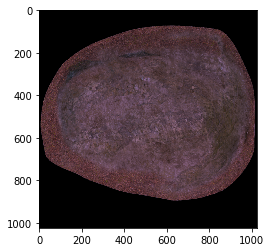

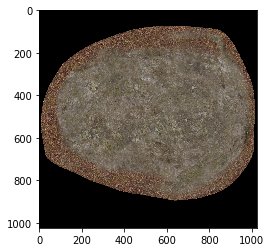

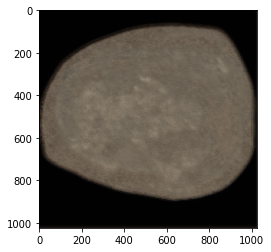

In [140]:
label, img = test_lighted_data[40]
plt.imshow(img)
plt.show()
plt.imshow(delighted_data[label])
plt.show()
plt.imshow(float_to_uint8(generator.predict(np.array([img])))[0])
plt.show()